In [1]:
!pip install gensim --quiet

In [2]:
!pip install tensorflow-datasets --quiet

In [3]:
!pip install -U tensorflow-text --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 36.6 MB/s eta 0:00:00


pydot is also required, along with **graphviz**.

In [4]:
!pip install pydot --quiet

Ready to do the imports.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
DataPath = '/content/drive/MyDrive/New_Delhi_reviews.csv'

Mounted at /content/drive


Below is a helper function to plot histories.

In [6]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [7]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [8]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [10]:
len(model)

43981

In [11]:
model['great']

array([ 3.06035e-02,  8.86877e-02, -1.21269e-02,  7.61965e-02,
        5.66269e-02, -4.24702e-02,  4.10129e-02, -4.97567e-02,
       -3.64328e-03,  6.32889e-02, -1.42608e-02, -7.91111e-02,
        1.74877e-02, -3.83064e-02,  9.26433e-03,  2.95626e-02,
        7.70293e-02,  9.49334e-02, -4.28866e-02, -2.95626e-02,
        4.45244e-05,  6.82854e-02,  1.73836e-02,  3.14363e-02,
        6.53708e-02,  2.89380e-02, -4.39275e-02,  1.78000e-02,
        1.82164e-02, -4.70503e-02, -2.85216e-02,  1.79041e-02,
        1.06592e-01,  9.07696e-02,  6.78690e-02,  6.16755e-03,
       -2.08187e-02,  5.95936e-03,  1.51586e-03,  8.95205e-02,
        6.49544e-02, -3.12281e-02,  9.24351e-02, -2.45661e-02,
       -1.21269e-02, -1.53538e-03,  6.49544e-02, -1.12421e-02,
        9.10819e-03, -6.45380e-02,  4.43439e-02,  1.35738e-01,
       -7.91111e-02,  1.57181e-02, -4.72585e-02, -1.35322e-02,
       -4.33029e-02, -5.16304e-02,  1.37404e-01, -3.12281e-02,
       -6.49544e-02,  1.14087e-01, -6.41217e-02, -5.246

We can now build the embedding matrix and a vocabulary dictionary:

In [12]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [13]:
embedding_matrix.shape

(43982, 300)

In [14]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

In [15]:
#Load data from csv on Google drive into pandas df, easiest for data analysis
df = pd.read_csv(DataPath)

#Split data into 80/20 train test sets
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
testdf= df[~msk]

#print(len(test_data))
#print(len(train_data))

#Split data and labels into Numpy arrays
train_data = np.array(traindf['review_full'])
train_labels = np.array(traindf['rating_review'])
test_data = np.array(testdf['review_full'])
test_labels = np.array(testdf['rating_review'])

In [16]:
#Cast data types explicitly in nparrays to avoid errors
train_data = train_data.astype(str)
test_data = test_data.astype(str)
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

#Convert data into tensors
t_train_data = tf.constant(train_data)
t_test_data = tf.constant(test_data)
t_train_labels = tf.convert_to_tensor(train_labels)
t_test_labels = tf.convert_to_tensor(test_labels)
t_test_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([5, 5, 5, 5])>

In [19]:
train_labels[:4]

array([5, 5, 5, 5])

In [20]:
#Tokenize the data
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(t_train_data)
test_tokens = tokenizer.tokenize(t_test_data)

In [21]:
train_tokens[0]

<tf.Tensor: shape=(37,), dtype=string, numpy=
array([b'I', b'went', b'this', b'bar', b'8', b'days', b'regularly',
       b'with', b'my', b'husband..', b'we', b'are', b'fully',
       b'satisfied', b'by', b'the', b'services.', b'Staff', b'is',
       b'very', b'good', b'(vitoni', b'and', b'amen)', b'they', b'both',
       b'served', b'us', b'daily', b'.', b'Will', b'surely', b'visit',
       b'again.', b'Highly', b'recommended', b'\xe2\x9d\xa3\xef\xb8\x8f'],
      dtype=object)>

### 2.2 Data Preparation

In [22]:
MAX_SEQUENCE_LENGTH = 128

In [23]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [24]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

#train_labels = np.array(train_labels)
#test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Examples processed:  40000
Examples processed:  45000
Examples processed:  50000
Examples processed:  55000
Examples processed:  60000
Examples processed:  65000
Examples processed:  70000
Examples processed:  75000
Examples processed:  80000
Examples processed:  85000
Examples processed:  90000
Examples processed:  95000
Examples processed:  100000
Examples processed:  105000
Examples processed:  110000
Examples processed:  115000
Total examples:  118146
Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Total examples:  29433


In [25]:
train_input[:2]

array([[12139, 38597, 35029, 38751, 29190,  6999,  7904,  1331, 19334,
        43981, 25069, 42958,  3984, 35828, 12929, 14193, 43981, 13124,
        16908, 15108, 39933, 43981, 43981, 43981, 16030, 37437, 28640,
        12050, 39039, 43981, 35803, 13272,  6264, 43981, 23827,  1922,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [26]:
train_labels[:4]

array([5, 5, 5, 5])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling

<a id = 'averagingNetwork'></a>
### 3.1 Averaging Network (AN) Model

In [27]:
an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [28]:
an_embedding_layer = Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)

In [29]:
an_embeddings = an_embedding_layer(an_input_layer)

In [30]:
an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)

In [31]:
an_classification = tf.keras.layers.Dense(5,
                                                      activation='softmax',
                                                      name='an_multiclass_classification')(an_avg_embeddings)

In [32]:
an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])

In [33]:
an_model.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    amsgrad=False,
                                                    name='Adam'),
                 metrics='accuracy')

In [34]:
an_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_multiclass_classificati  (None, 5)                 1505      
 on (Dense)                                                      
                                                                 
Total params: 13196105 (50.34 MB)
Trainable params: 1505 (5.88 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________


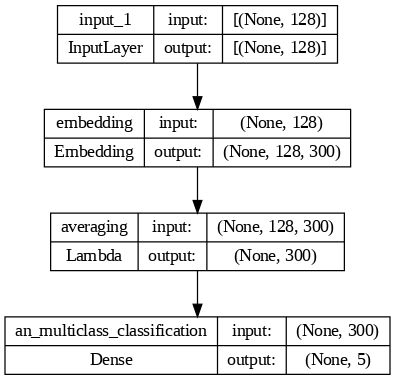

In [35]:
keras.utils.plot_model(an_model, show_shapes=True, dpi=90)

In [36]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 3s 3s/step
predictions:
 [[0.20079412 0.198816   0.1985244  0.20052741 0.20133805]
 [0.20124923 0.19888532 0.19817556 0.2016478  0.2000421 ]
 [0.20276573 0.19734572 0.1979748  0.20119931 0.20071444]
 [0.2043394  0.19741495 0.19689067 0.20078143 0.2005736 ]
 [0.20242083 0.19463576 0.19941907 0.20438999 0.1991343 ]]


labels:
 [5 5 5 5 5]


In [37]:
from tensorflow.keras.utils import to_categorical

train_labels = train_labels - 1
test_labels = test_labels - 1

train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

#train_labels[:4]

an_history = an_model.fit(train_input,
                          train_labels,
                          validation_data=(test_input, test_labels),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
3693/3693 [==============================] - 17s 4ms/step - loss: 0.4377 - accuracy: 0.4919 - val_loss: 0.3953 - val_accuracy: 0.5025
Epoch 2/20
3693/3693 [==============================] - 14s 4ms/step - loss: 0.3815 - accuracy: 0.5051 - val_loss: 0.3743 - val_accuracy: 0.5075
Epoch 3/20
3693/3693 [==============================] - 14s 4ms/step - loss: 0.3679 - accuracy: 0.5125 - val_loss: 0.3659 - val_accuracy: 0.5159
Epoch 4/20
3693/3693 [==============================] - 14s 4ms/step - loss: 0.3617 - accuracy: 0.5195 - val_loss: 0.3612 - val_accuracy: 0.5231
Epoch 5/20
3693/3693 [==============================] - 14s 4ms/step - loss: 0.3576 - accuracy: 0.5266 - val_loss: 0.3578 - val_accuracy: 0.5252
Epoch 6/20
3693/3693 [==============================] - 14s 4ms/step - loss: 0.3545 - accuracy: 0.5308 - val_loss: 0.3551 - val_accuracy: 0.5276
Epoch 7/20
3693/3693 [==============================] - 14s 4ms/step - loss: 0.3520 - accuracy: 0.5352 - val_loss: 0.3528 - val_ac

In [38]:
len(test_labels)

29434

Let's revisit the predictions. How is this?

In [39]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 0s 29ms/step
predictions:
 [[0.01060643 0.00759643 0.02124432 0.12299103 0.8375617 ]
 [0.01036235 0.01282133 0.05238097 0.24754496 0.6768904 ]
 [0.01190248 0.01297369 0.03849436 0.27208102 0.6645484 ]
 [0.0112497  0.00766518 0.01352035 0.09599525 0.8715696 ]
 [0.02065758 0.03554935 0.07426028 0.34772816 0.52180463]]


labels:
 [[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


<a id = 'modelDAN'></a>
### 3.2. Deep Averaging Network (DAN)

In [40]:
def build_dan_model(hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)

    dan_classification = tf.keras.layers.Dense(5,
                                               activation='sigmoid',
                                               name='dan_classification')(last_hidden_output)

    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

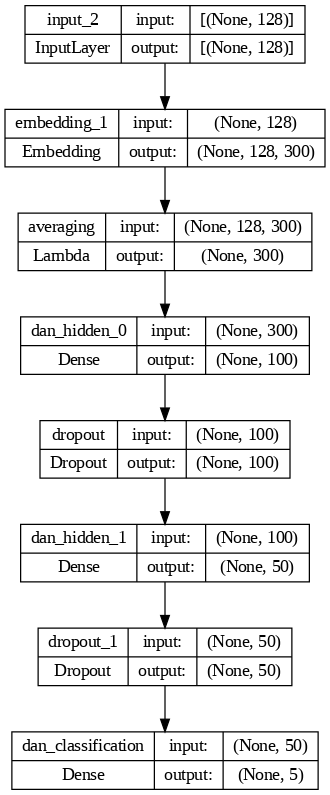

In [41]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5

dan_model = build_dan_model(hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [42]:
dan_history = dan_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20
3693/3693 [==============================] - 19s 5ms/step - loss: 0.3635 - accuracy: 0.5248 - val_loss: 0.3289 - val_accuracy: 0.5652
Epoch 2/20
3693/3693 [==============================] - 16s 4ms/step - loss: 0.3310 - accuracy: 0.5697 - val_loss: 0.3210 - val_accuracy: 0.5826
Epoch 3/20
3693/3693 [==============================] - 17s 5ms/step - loss: 0.3251 - accuracy: 0.5787 - val_loss: 0.3174 - val_accuracy: 0.5845
Epoch 4/20
3693/3693 [==============================] - 16s 4ms/step - loss: 0.3218 - accuracy: 0.5839 - val_loss: 0.3157 - val_accuracy: 0.5868
Epoch 5/20
3693/3693 [==============================] - 17s 5ms/step - loss: 0.3206 - accuracy: 0.5878 - val_loss: 0.3153 - val_accuracy: 0.5870
Epoch 6/20
3693/3693 [==============================] - 16s 4ms/step - loss: 0.3194 - accuracy: 0.5881 - val_loss: 0.3129 - val_accuracy: 0.5910
Epoch 7/20
3693/3693 [==============================] - 17s 5ms/step - loss: 0.3187 - accuracy: 0.5891 - val_loss: 0.3126 - val_ac

Below is a sample plot for two different models:

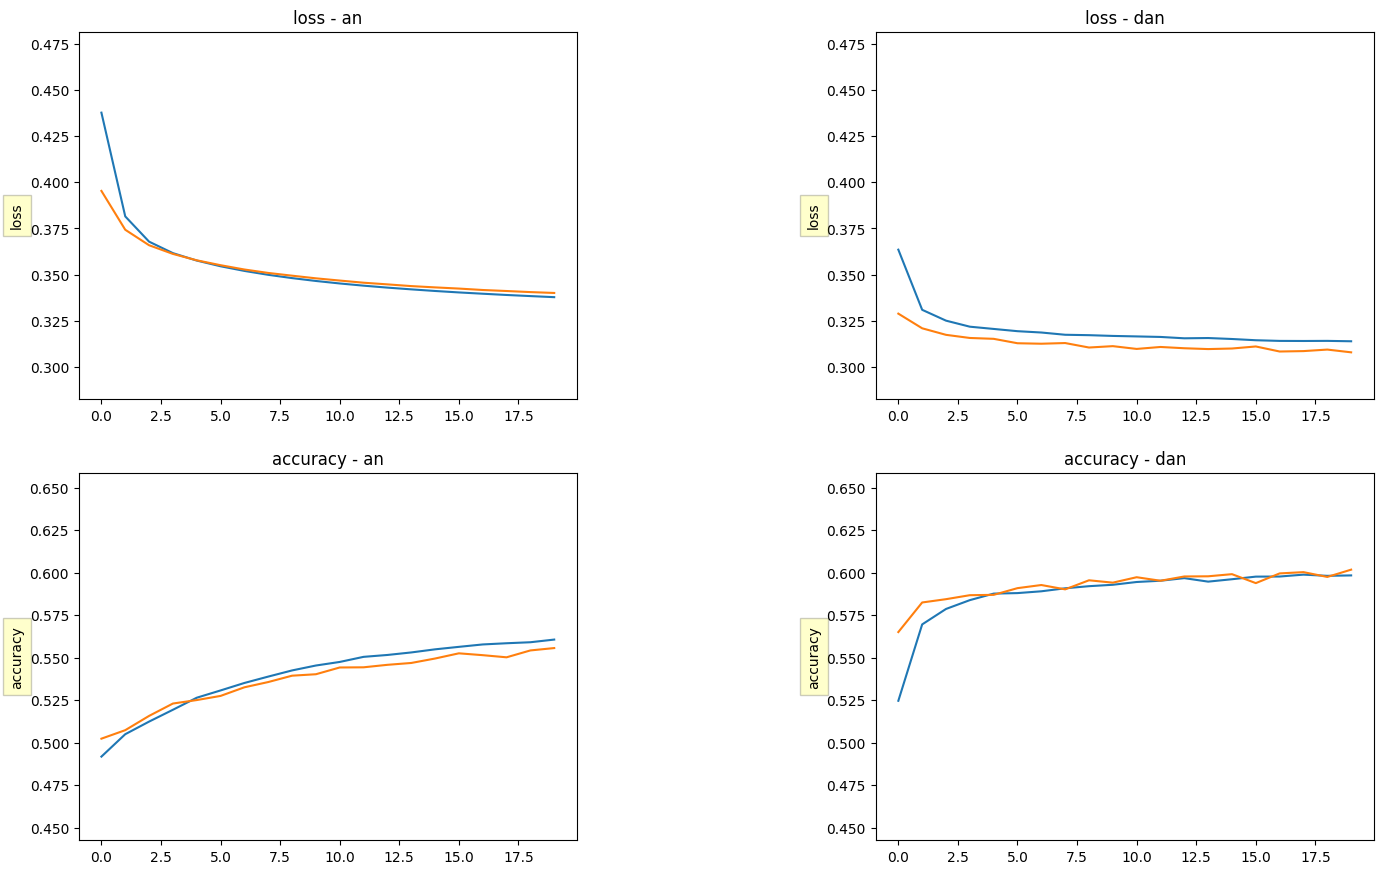

In [43]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          an_history,
          dan_history,
          model_1_name='an',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

<a id = 'modelCNN'></a>
### 3.3 CNN Model

In [44]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(5, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [45]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [46]:
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 128, 300)             1319460   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 126, 100)             90100     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 125, 100)             120100    ['embedding_2[0][0]']   

The keras plot utility shows this probably a bit nicer:

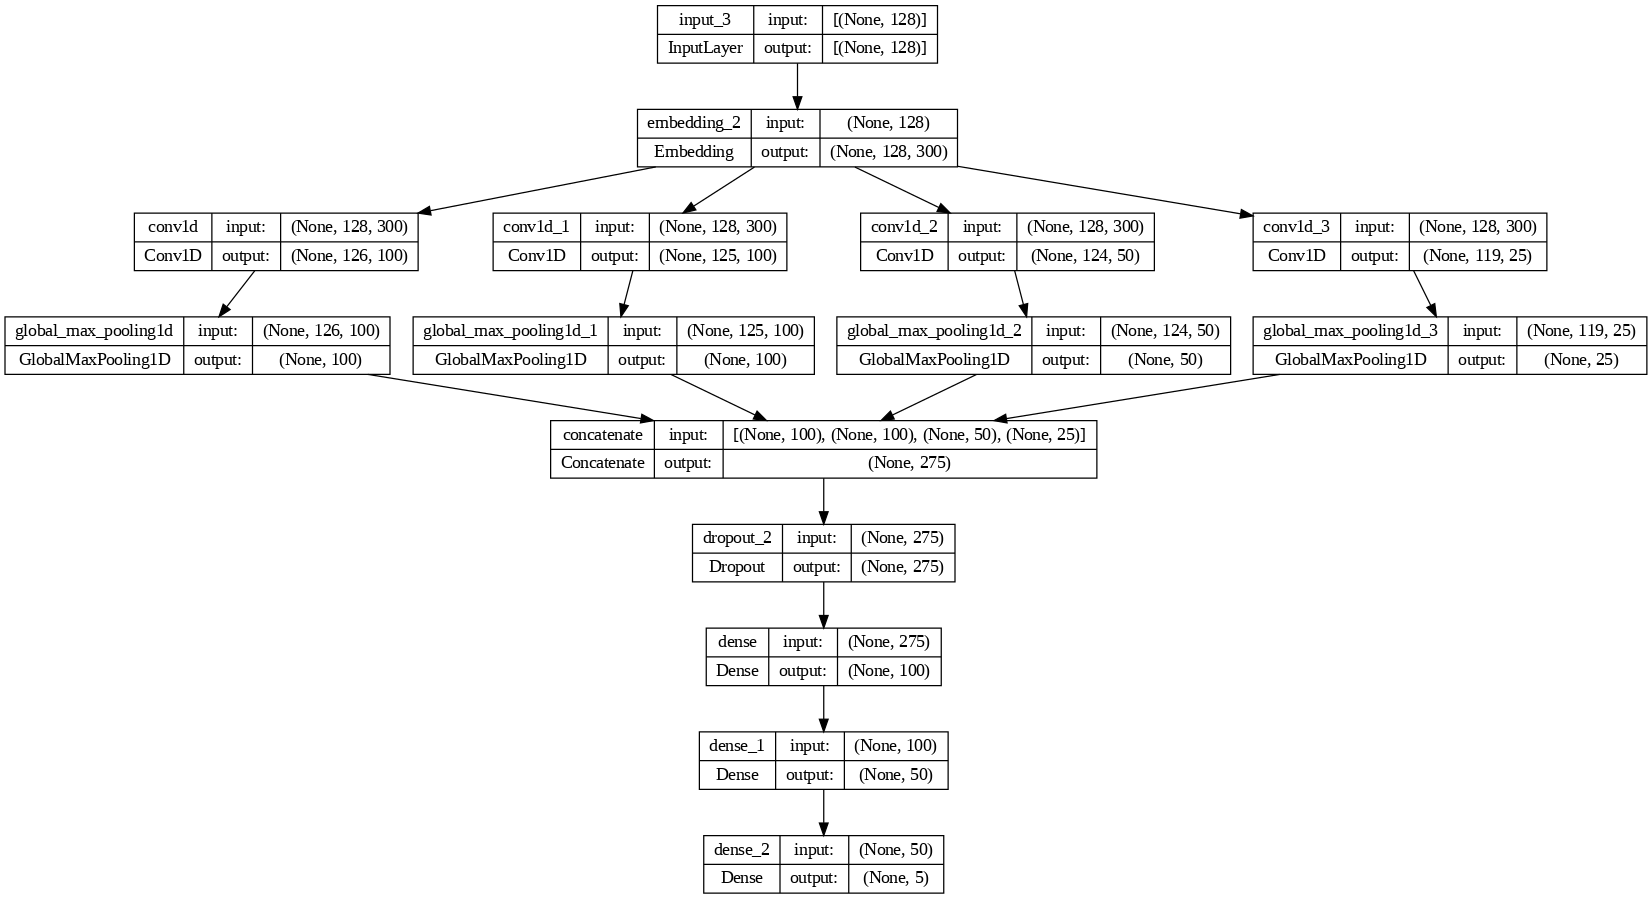

In [47]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [48]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
3693/3693 [==============================] - 41s 9ms/step - loss: 0.3207 - accuracy: 0.5860 - val_loss: 0.2965 - val_accuracy: 0.6207
Epoch 2/5
3693/3693 [==============================] - 31s 8ms/step - loss: 0.2977 - accuracy: 0.6194 - val_loss: 0.2934 - val_accuracy: 0.6236
Epoch 3/5
3693/3693 [==============================] - 31s 8ms/step - loss: 0.2902 - accuracy: 0.6342 - val_loss: 0.2895 - val_accuracy: 0.6293
Epoch 4/5
3693/3693 [==============================] - 43s 12ms/step - loss: 0.2851 - accuracy: 0.6402 - val_loss: 0.2882 - val_accuracy: 0.6332
Epoch 5/5
3693/3693 [==============================] - 32s 9ms/step - loss: 0.2801 - accuracy: 0.6491 - val_loss: 0.2882 - val_accuracy: 0.6317


Comparing our CNN model with the DAN model:

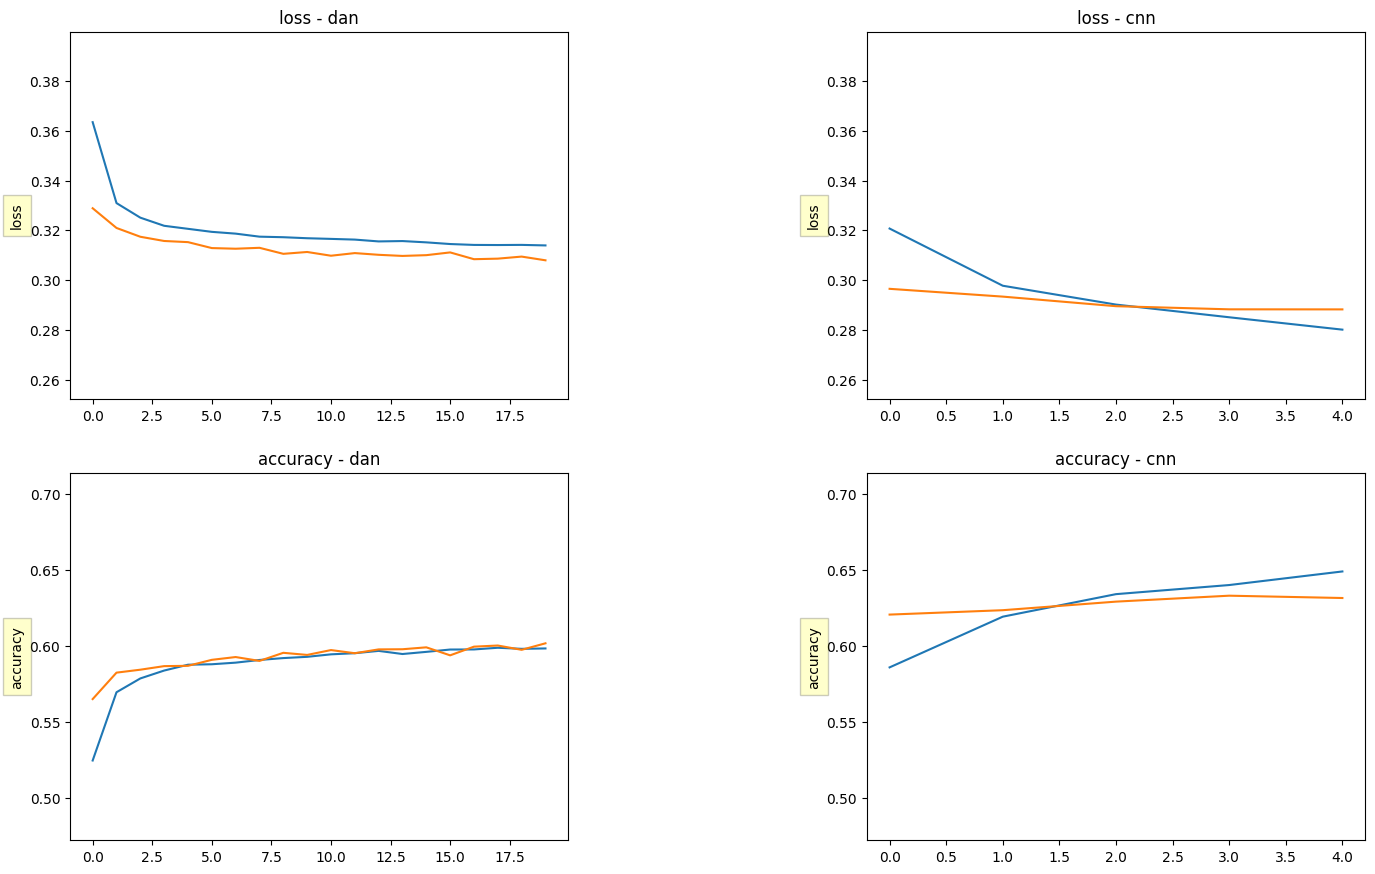

In [49]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_history,
          cnn_history,
          model_1_name='dan',
          model_2_name='cnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

<a id = 'modelRNN'></a>
### 3.4 Recurrent Neural Network (RNN)

#### 3.4.1. Basic Tests

In [50]:
def build_basic_rnn_model(max_length,
                          rnn_dim,
                          return_sequences,
                          return_state):
    """
    max_length:         maximum input length
    rnn_dim:            dimension of the rnn
    return_sequences:   should the entire sequence of output vectors for each time step be returned?
    return_state:       should the final cell states get returned?
    """

    # inputs - comprised of - for each example in mini-batch:
    #             - (<max_length>) x_t, each of dim <rnn_dim>,
    #.            - the initial 2 x 3d state (h and c)

    in_x = tf.keras.layers.Input(shape=(max_length, rnn_dim), name="in_id")
    in_state_h = tf.keras.layers.Input(shape=(rnn_dim,), name="in_state_h")
    in_state_c = tf.keras.layers.Input(shape=(rnn_dim,), name="in_state_c")

    # define a very simple lstm layer, acting on the input

    lstm_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=return_sequences, return_state=return_state)\
            (in_x, initial_state=[in_state_h, in_state_c])

    model = tf.keras.models.Model(inputs=[in_x, in_state_h, in_state_c], outputs=lstm_output)

    return model

In [51]:
basic_rnn_model = build_basic_rnn_model(max_length=4,
                                        rnn_dim=3,
                                        return_sequences=True,
                                        return_state=True)

In [52]:
basic_rnn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_id (InputLayer)          [(None, 4, 3)]               0         []                            
                                                                                                  
 in_state_h (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 in_state_c (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 4, 3),               84        ['in_id[0][0]',               
                              (None, 3),                             'in_state_h[0][0]',    

In [53]:
basic_rnn_model_no_return_sequence = build_basic_rnn_model(max_length=4,
                                                           rnn_dim=3,
                                                           return_sequences=False,
                                                           return_state=True)

In [54]:
basic_rnn_model_no_return_sequence.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_id (InputLayer)          [(None, 4, 3)]               0         []                            
                                                                                                  
 in_state_h (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 in_state_c (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 lstm_1 (LSTM)               [(None, 3),                  84        ['in_id[0][0]',               
                              (None, 3),                             'in_state_h[0][0]',    

In [55]:
basic_rnn_model_no_return_state = build_basic_rnn_model(max_length=4,
                                                        rnn_dim=3,
                                                        return_sequences=True,
                                                        return_state=False)

In [56]:
basic_rnn_model_no_return_state.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_id (InputLayer)          [(None, 4, 3)]               0         []                            
                                                                                                  
 in_state_h (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 in_state_c (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 4, 3)                 84        ['in_id[0][0]',               
                                                                     'in_state_h[0][0]',    

In [57]:
basic_rnn_model_no_return_state_no_sequences = build_basic_rnn_model(max_length=4,
                                                                     rnn_dim=3,
                                                                     return_sequences=False,
                                                                     return_state=False)

In [58]:
basic_rnn_model_no_return_state_no_sequences.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_id (InputLayer)          [(None, 4, 3)]               0         []                            
                                                                                                  
 in_state_h (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 in_state_c (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 3)                    84        ['in_id[0][0]',               
                                                                     'in_state_h[0][0]',    

In [59]:
lstm_input = np.array([[[1.1,2,3], [4,5,6], [7,8,9], [10,11,12]]])
initial_h = np.array([[1.,4,3]]*1)
initial_c = np.array([[1,2,6]]*1)

out, state_h, state_c = basic_rnn_model.predict([lstm_input, initial_h, initial_c],
                                                batch_size=4)

print('output_vector', out)
print('out_state_h ', state_h)
print('out_state_c ', state_c)

1/1 [==============================] - 1s 826ms/step
output_vector [[[ 0.02196916  0.58523977 -0.01864698]
  [ 0.3035188   0.14512984 -0.08446087]
  [ 0.18775408  0.05934283 -0.03244912]
  [ 0.09489051  0.0259435  -0.01001839]]]
out_state_h  [[ 0.09489051  0.0259435  -0.01001839]]
out_state_c  [[ 2.6187065  1.8066361 -0.9660702]]


#### 3.4.2. RNN for TripAdvisor Review Classification

In [60]:
def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    rnn_prediction = keras.layers.Dense(5, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  
                      metrics=['accuracy'])
    return rnn_model

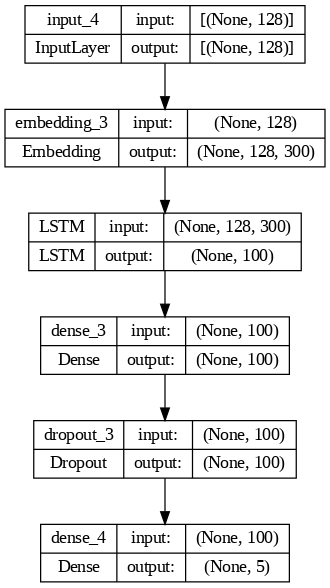

In [61]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [62]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
3693/3693 [==============================] - 41s 10ms/step - loss: 0.3930 - accuracy: 0.4867 - val_loss: 0.3854 - val_accuracy: 0.4936
Epoch 2/5
3693/3693 [==============================] - 36s 10ms/step - loss: 0.3394 - accuracy: 0.5514 - val_loss: 0.3172 - val_accuracy: 0.5891
Epoch 3/5
3693/3693 [==============================] - 35s 9ms/step - loss: 0.3143 - accuracy: 0.5934 - val_loss: 0.3061 - val_accuracy: 0.6071
Epoch 4/5
3693/3693 [==============================] - 35s 9ms/step - loss: 0.3034 - accuracy: 0.6130 - val_loss: 0.2968 - val_accuracy: 0.6197
Epoch 5/5
3693/3693 [==============================] - 36s 10ms/step - loss: 0.2947 - accuracy: 0.6276 - val_loss: 0.2931 - val_accuracy: 0.6216


Let's compare this to the CNN results:

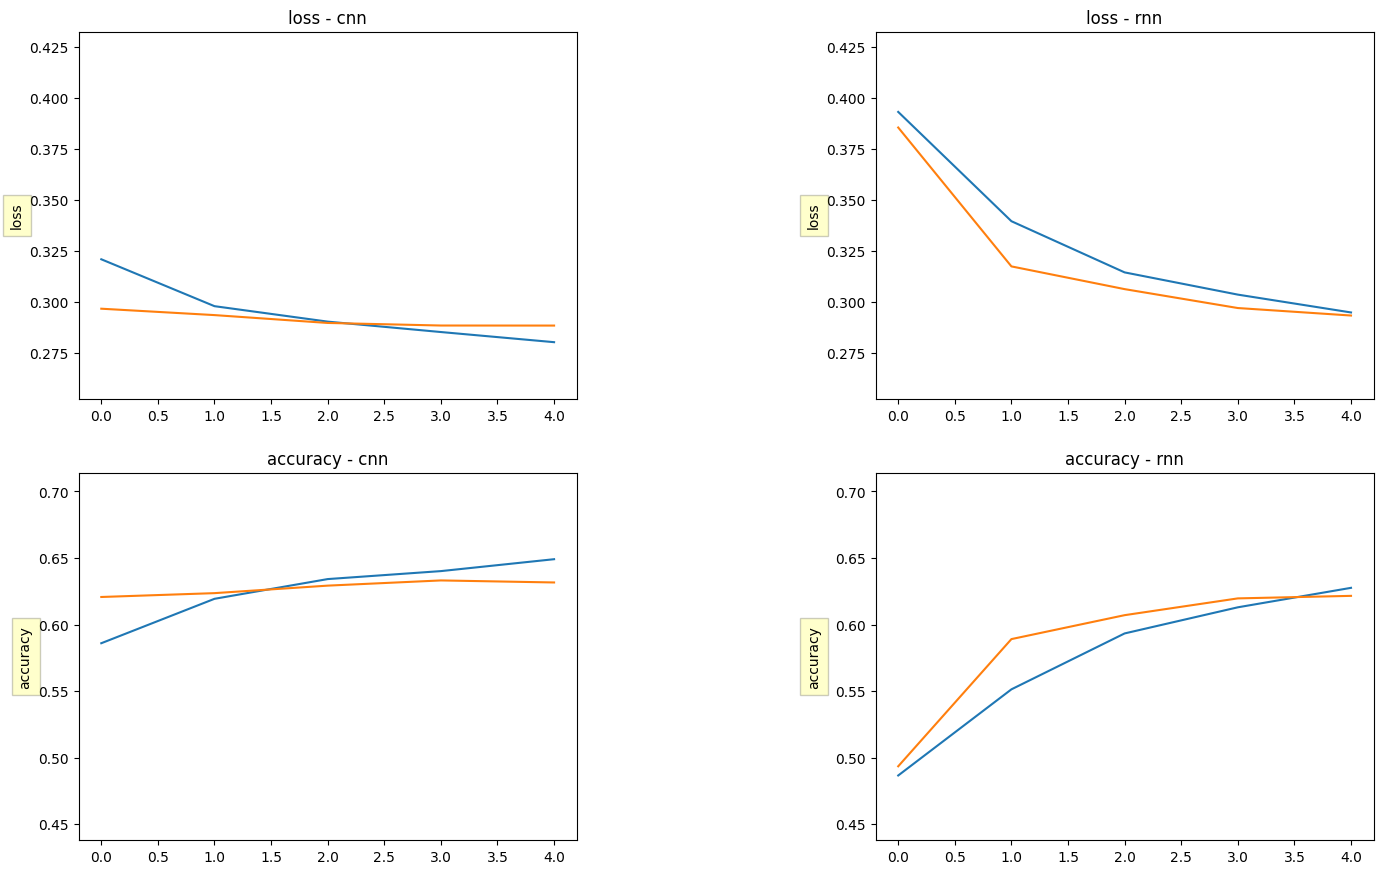

In [63]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          rnn_history,
          model_1_name='cnn',
          model_2_name='rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()